Autor: Alejandro Burgueño Díaz. 17/08/2021.

NOTA: ESTE NOTEBOOK HA SIDO DESARROLLADO EN GOOGLE COLAB PARA BENEFICIARSE DE LAS GPU. ALGUNAS LÍNEAS DE CÓDIGO SON NECESARIAS PARA EJECUTAR EL PROGRAMA.

# 0 - LIBRERÍAS Y ANÁLISIS DEL DATASET

In [1]:
# Importación de librerías generales
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
print(tf.__version__)

2.5.0


In [2]:
# Descarga del dataset a través de Github (método aplicable a Google Colab)
url = 'https://raw.githubusercontent.com/retrospectivePreposterous/Classification-Regression/main/AirQualityUCI.csv'
air_q = pd.read_csv(url)

In [3]:
# Visualización del dataset
air_q

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,10/03/2004,18:00:00,2.6,1360,150,11.9,1046,166,1056,113,1692,1268,13.6,48.9,0.7578
1,10/03/2004,19:00:00,2.0,1292,112,9.4,955,103,1174,92,1559,972,13.3,47.7,0.7255
2,10/03/2004,20:00:00,2.2,1402,88,9.0,939,131,1140,114,1555,1074,11.9,54.0,0.7502
3,10/03/2004,21:00:00,2.2,1376,80,9.2,948,172,1092,122,1584,1203,11.0,60.0,0.7867
4,10/03/2004,22:00:00,1.6,1272,51,6.5,836,131,1205,116,1490,1110,11.2,59.6,0.7888
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9352,04/04/2005,10:00:00,3.1,1314,-200,13.5,1101,472,539,190,1374,1729,21.9,29.3,0.7568
9353,04/04/2005,11:00:00,2.4,1163,-200,11.4,1027,353,604,179,1264,1269,24.3,23.7,0.7119
9354,04/04/2005,12:00:00,2.4,1142,-200,12.4,1063,293,603,175,1241,1092,26.9,18.3,0.6406
9355,04/04/2005,13:00:00,2.1,1003,-200,9.5,961,235,702,156,1041,770,28.3,13.5,0.5139


Se comprueba que la variable Time son horas en punto, y que el paso es de hora en hora completándose entonces ciclos de 24 horas. 

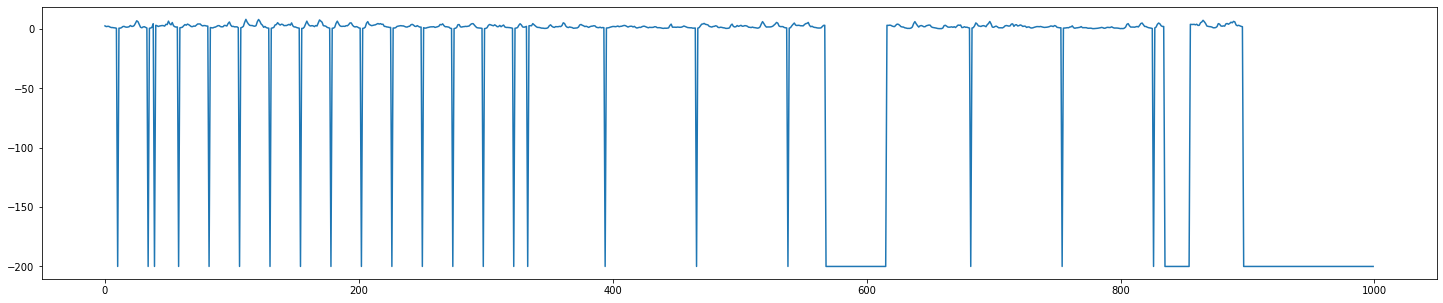

In [24]:
# Visualización de algunas variables en función del tiempo
plt.rcParams['figure.figsize'] = [25, 5]
plt.plot(air_q['CO(GT)'][0:1000])

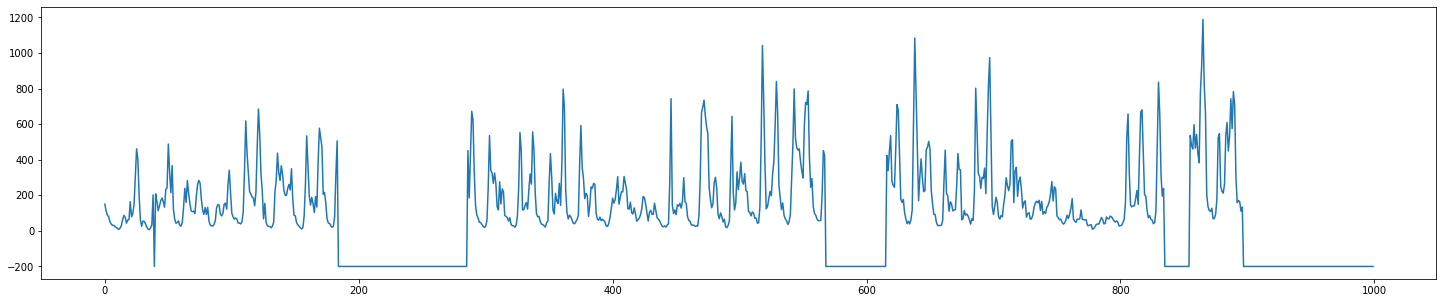

In [25]:
plt.plot(air_q['NMHC(GT)'][0:1000])

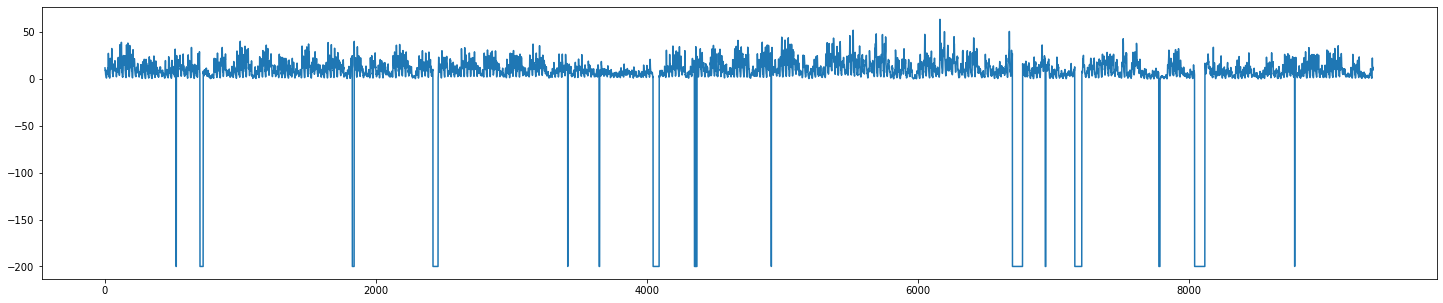

In [4]:
plt.plot(air_q['C6H6(GT)'])

OBSERVACIONES: Se percibe que las variables tienen datos anómalos, generalmente cayendo al valor -200. Estos valores pueden ser debido a una saturación del sensor de gases, una caída de la instalación eléctrica o un malfuncionamiento.

# 1- MÉTODO A: SERIES TEMPORALES

Vistos los análisis previos parece lógico resolver la regresión a través de series temporales, ya que a pesar de los outliers se aprecian oscilaciones periódicas en los datos.  
Como prueba se emplea la variable C6H6(GT) como variable predictora, y se utilizará una RRN del tipo LSTM (Long Short Term Memory)

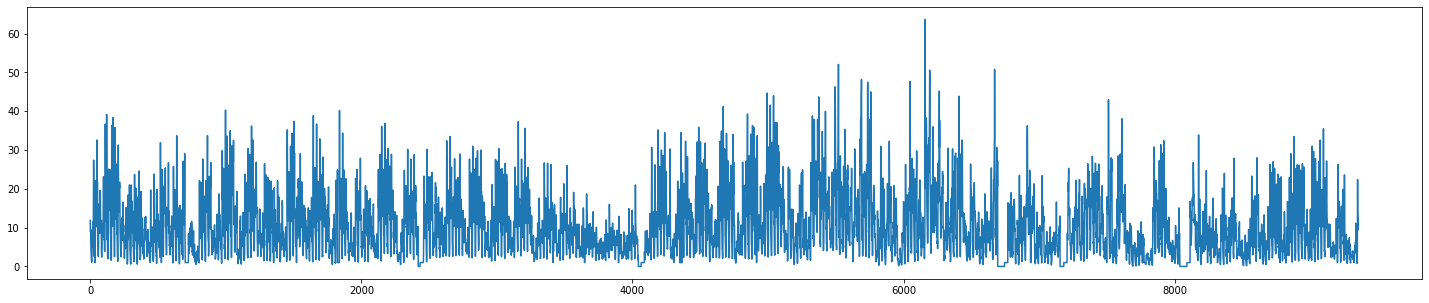

In [5]:
# Se corrigen los valores anómalos.
# En lugar de una media o anularlos, se procede a igualar dichos valores a los valores tomados la misma hora el día anterior
air_q = air_q.rename(columns={'C6H6(GT)': 'C6H6_GT'})
air_q.loc[air_q.C6H6_GT == -200, 'C6H6_GT'] = air_q.C6H6_GT.shift(-24) != -200
plt.plot(air_q['C6H6_GT'])

OBSERVACIONES: A pesar de que todavía parece mantenerse algún valor anómalo (espacios continuados en rectas) los datos de entrada parecen razonables para ser evaluados

In [6]:
# Se asigna la variable predictora a un array 'series' y el paso temporal (cada hora) se asigna a un step 'time'.
series = air_q['C6H6_GT'].to_numpy()
series= np.asarray(series).astype('float32')
print(series)

time = [x for x in range(len(series))]
time= np.asarray(time).astype('float32')
print(time)

[11.9  9.4  9.  ... 12.4  9.5 11.9]
[0.000e+00 1.000e+00 2.000e+00 ... 9.354e+03 9.355e+03 9.356e+03]


In [7]:
# Se generan variables para la técnica de la ventana temporal, que 'memorizará' un buffer de información
split_time = 2500
window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

# Split del dataset en entrenamiento y validación
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [8]:
# Funciones del dataset dentro de la ventana temporal, así como del pronóstico del modelo
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [9]:
def model_forecast(model, series, window_size):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size))
  ds = ds.batch(32).prefetch(1)
  forecast = model.predict(ds)
  return forecast

In [10]:
# Se restaura la sesión de keras para inicializar el modelo
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 60
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer=shuffle_buffer_size)

In [27]:
# Modelo de red neuronal basado en una convolución de 60 filtros de 5x5 y stride de 1 paso; agregando dos capas Long Short Term Memory. 
# Se aplican funciones de activación relu
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                         strides=1,padding="causal",
                         activation="relu",input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

In [12]:
# Se genera una variable lr_schedule con el fin de poder analizar el momento en que el Learning rate se dispara después
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

In [13]:
# Se incorpora un callback para evitar sobrepasar el laerning rate
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
# Se optimiza el Descenso de Gradiente Estocástico con un momentum, con el fin de evitar caer en mínimos locales o puntos de silla
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [14]:
# Se entrena un primer modelo con 100 epocs y el callback definido anteriormente
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
10/10 [==============================] - 5s 24ms/step - loss: 11.3591 - mae: 11.8493
Epoch 2/100
10/10 [==============================] - 0s 28ms/step - loss: 10.9019 - mae: 11.3918
Epoch 3/100
10/10 [==============================] - 0s 28ms/step - loss: 10.3496 - mae: 10.8397
Epoch 4/100
10/10 [==============================] - 0s 28ms/step - loss: 9.8979 - mae: 10.3878
Epoch 5/100
10/10 [==============================] - 0s 29ms/step - loss: 9.5409 - mae: 10.0303
Epoch 6/100
10/10 [==============================] - 0s 28ms/step - loss: 9.2798 - mae: 9.7695
Epoch 7/100
10/10 [==============================] - 0s 28ms/step - loss: 9.0427 - mae: 9.5324
Epoch 8/100
10/10 [==============================] - 0s 29ms/step - loss: 8.8063 - mae: 9.2958
Epoch 9/100
10/10 [==============================] - 0s 27ms/step - loss: 8.5630 - mae: 9.0523
Epoch 10/100
10/10 [==============================] - 0s 29ms/step - loss: 8.3101 - mae: 8.7996
Epoch 11/100
10/10 [=====================

(1e-08, 0.0001, 0.0, 60.0)

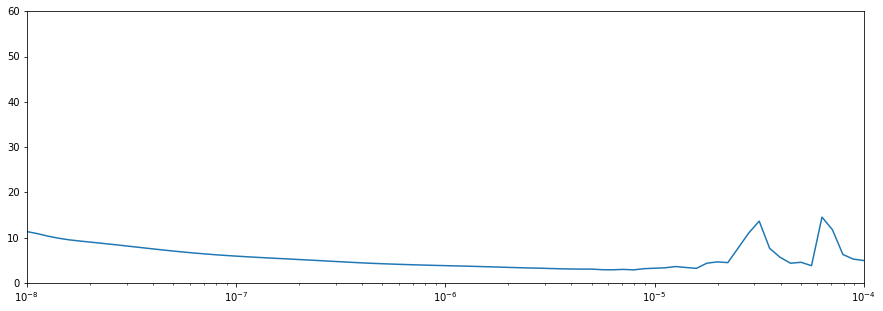

In [15]:
# Se representa la evolución del Learning Rate para comprobar a partir de qué punto es inutil, con el fin de re-entrenar el modelo
plt.rcParams['figure.figsize'] = [15, 5]
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [16]:
# Se comprueba que el learning rate más adecuado es 1e-5
learning_rate=1e-5

In [17]:
# Se vuelve a iniciar la sesión
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 60
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer=shuffle_buffer_size)

In [18]:
# En esta ocasión se aplica el Learning Rate de 1e-5 definido más arriba
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [19]:
# Se entrena el modelo definitivo y se guardan los pesos en history.h5, con el fin de poder generar predicciones más fácilmente en el programa
history = model.fit(train_set,epochs=150)

model.save_weights('history.h5') 

Epoch 1/150
10/10 [==============================] - 3s 21ms/step - loss: 18.3004 - mae: 18.7942
Epoch 2/150
10/10 [==============================] - 0s 28ms/step - loss: 10.3783 - mae: 10.8710
Epoch 3/150
10/10 [==============================] - 0s 28ms/step - loss: 6.8610 - mae: 7.3444
Epoch 4/150
10/10 [==============================] - 0s 27ms/step - loss: 5.4689 - mae: 5.9525
Epoch 5/150
10/10 [==============================] - 0s 28ms/step - loss: 5.2689 - mae: 5.7504
Epoch 6/150
10/10 [==============================] - 0s 28ms/step - loss: 5.1167 - mae: 5.5984
Epoch 7/150
10/10 [==============================] - 0s 28ms/step - loss: 5.0405 - mae: 5.5200
Epoch 8/150
10/10 [==============================] - 0s 29ms/step - loss: 5.0385 - mae: 5.5178
Epoch 9/150
10/10 [==============================] - 0s 29ms/step - loss: 5.0405 - mae: 5.5201
Epoch 10/150
10/10 [==============================] - 0s 29ms/step - loss: 5.0304 - mae: 5.5094
Epoch 11/150
10/10 [=========================

In [20]:
# Se obtiene el pronóstico del modelo de la función de la ventana temporal
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

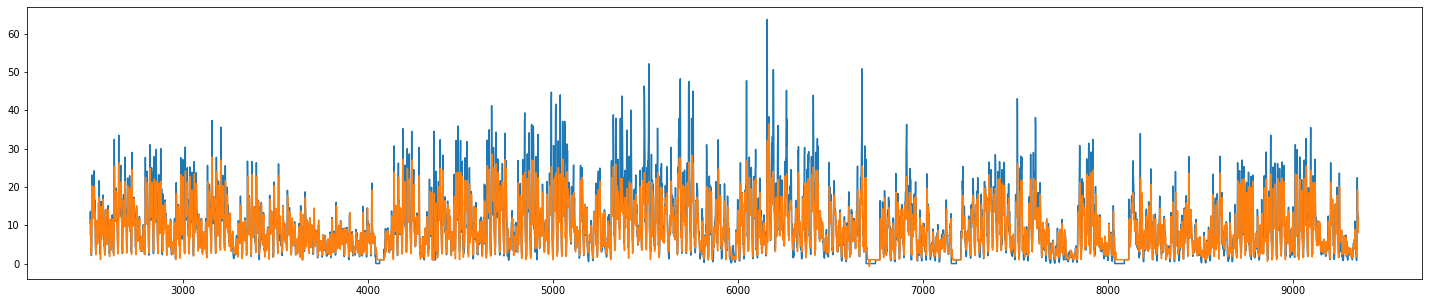

In [26]:
# Se representan los datos de entrada (azul) contra los datos predichos (naranja)
plt.rcParams['figure.figsize'] = [25, 5]
plt.plot(time_valid, x_valid)
plt.plot(time_valid, rnn_forecast)

In [22]:
# La predicción puede extraerse, además, a través del siguiente array
print(rnn_forecast)

[ 7.604196  8.891187 11.380204 ... 11.142696 10.632773  8.099152]


OBSERVACIONES: Este método es aplicable para otras variables (en caso de que sean consideradas predictoras), en lugar de la empleada en la práctica.  
Otros métodos válidos para series temporales serían a traves de ARIMA u otros modelos auto regresivos.

# 2- MÉTODO B: REGRESIÓN LINEAL

In [86]:
# Importación de librerías generales
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sb 

from sklearn.model_selection import train_test_split
from sklearn import metrics

from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

In [41]:
# Se vuelve a descargar el dataset a través de Github (método aplicable a Google Colab)
url = 'https://raw.githubusercontent.com/retrospectivePreposterous/Classification-Regression/main/AirQualityUCI.csv'
air_q = pd.read_csv(url)

# Se convierte la columna Time en numérica con el fin de compararlo en las matrices de dispersión y correlación
air_q['Time'] = air_q.Time.replace({':00:00':' '}, regex=True)
air_q['Time'] = pd.to_numeric(air_q['Time'])
air_q

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,10/03/2004,18,2.6,1360,150,11.9,1046,166,1056,113,1692,1268,13.6,48.9,0.7578
1,10/03/2004,19,2.0,1292,112,9.4,955,103,1174,92,1559,972,13.3,47.7,0.7255
2,10/03/2004,20,2.2,1402,88,9.0,939,131,1140,114,1555,1074,11.9,54.0,0.7502
3,10/03/2004,21,2.2,1376,80,9.2,948,172,1092,122,1584,1203,11.0,60.0,0.7867
4,10/03/2004,22,1.6,1272,51,6.5,836,131,1205,116,1490,1110,11.2,59.6,0.7888
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9352,04/04/2005,10,3.1,1314,-200,13.5,1101,472,539,190,1374,1729,21.9,29.3,0.7568
9353,04/04/2005,11,2.4,1163,-200,11.4,1027,353,604,179,1264,1269,24.3,23.7,0.7119
9354,04/04/2005,12,2.4,1142,-200,12.4,1063,293,603,175,1241,1092,26.9,18.3,0.6406
9355,04/04/2005,13,2.1,1003,-200,9.5,961,235,702,156,1041,770,28.3,13.5,0.5139


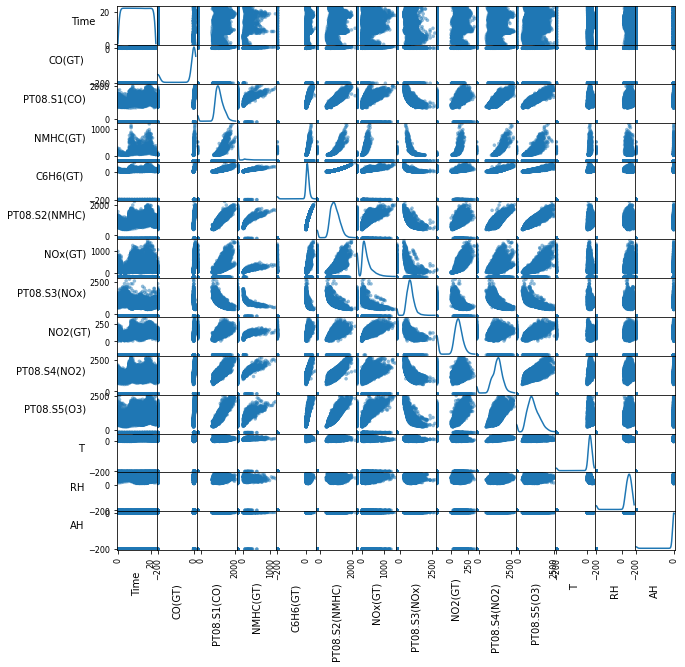

In [42]:
# Matriz de dispersión (scatter) y pares de variables
scatter_matrix = pd.plotting.scatter_matrix(
    air_q,
    figsize  = [10, 10],
    marker   = ".",
    s        = 50,
    diagonal = "kde"
)

for ax in scatter_matrix.ravel():
    ax.set_xlabel(ax.get_xlabel(), fontsize = 10, rotation = 90)
    ax.set_ylabel(ax.get_ylabel(), fontsize = 10, rotation = 0, ha='right')   

OBSERVACIONES: Se comprueba que el patrón de valores anómalos -200 sucede en muchas otras variables.

In [45]:
# Como el tiempo no es relevante en este método, se eliminan los valores anómalos sin atender a su remplazamiento en las 24 horas
for i in air_q:
  air_q = air_q[air_q[i] != -200]
air_q 

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,10/03/2004,18,2.6,1360,150,11.9,1046,166,1056,113,1692,1268,13.6,48.9,0.7578
1,10/03/2004,19,2.0,1292,112,9.4,955,103,1174,92,1559,972,13.3,47.7,0.7255
2,10/03/2004,20,2.2,1402,88,9.0,939,131,1140,114,1555,1074,11.9,54.0,0.7502
3,10/03/2004,21,2.2,1376,80,9.2,948,172,1092,122,1584,1203,11.0,60.0,0.7867
4,10/03/2004,22,1.6,1272,51,6.5,836,131,1205,116,1490,1110,11.2,59.6,0.7888
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1226,30/04/2004,20,4.4,1449,501,19.5,1282,254,625,133,2100,1569,19.1,61.1,1.3345
1227,30/04/2004,21,3.1,1363,234,15.1,1152,189,684,110,1951,1495,18.2,65.4,1.3529
1228,30/04/2004,22,3.0,1371,212,14.6,1136,174,689,102,1927,1471,18.1,66.1,1.3579
1229,30/04/2004,23,3.1,1406,275,13.7,1107,167,718,108,1872,1384,17.7,66.9,1.3422


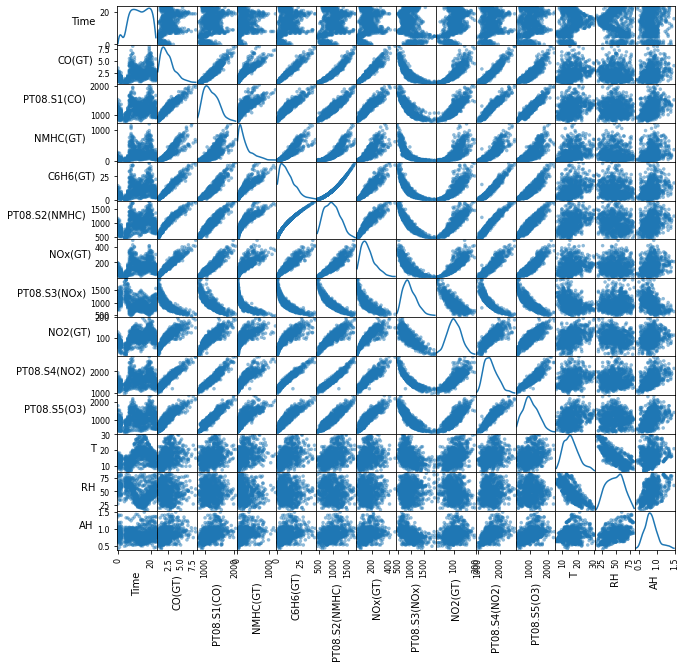

In [47]:
# El dataset ha quedado reducido a 827 filas, de las cuales, el resultado de la matriz de dispersión es el siguiente
scatter_matrix = pd.plotting.scatter_matrix(
    air_q,
    figsize  = [10, 10],
    marker   = ".",
    s        = 50,
    diagonal = "kde"
)

for ax in scatter_matrix.ravel():
    ax.set_xlabel(ax.get_xlabel(), fontsize = 10, rotation = 90)
    ax.set_ylabel(ax.get_ylabel(), fontsize = 10, rotation = 0, ha='right') 

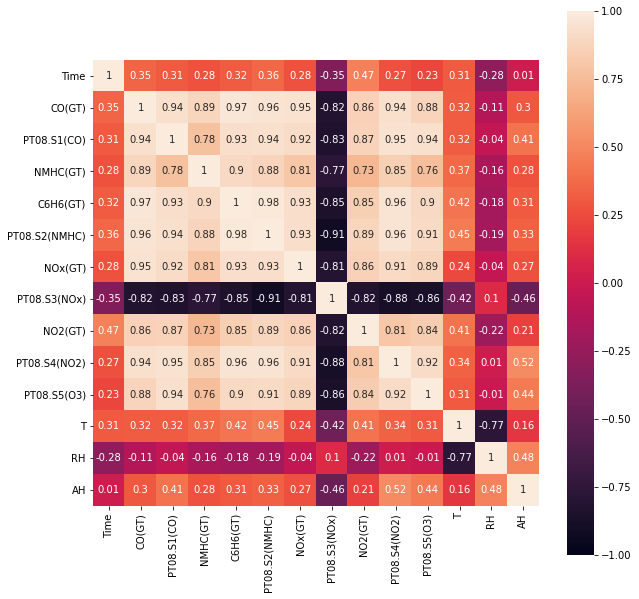

In [48]:
# Matriz de correlación
corrMatrix = air_q.corr()

plt.rcParams['figure.figsize'] = 10, 10
data = np.round(corrMatrix, 2)
sb.heatmap(data, annot = True, vmin=-1, vmax=1, square=True)

OBSERVACIONES: Se comprueba que tras eliminar los outliers todas las variables salvo T, RH, AH y Tiempo están fuertemente correlacionadas de manera directa, salvo PT08.S3(NOx), que lo hace de manera inversa (este fenómeno también puede apreciarse en la matriz de dispersión).  
Por lo tanto, para generar un modelo de regresión lineal, se pueden eliminar los gases de mismo signo de correlación ya que aportan la misma información.

In [51]:
# Se mantiene la variable CO(GT), eliminando el resto que mantienen una fuerte correlación directa
variables_to_drop = ['Date', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)']
air_q = air_q.drop(variables_to_drop, axis=1)

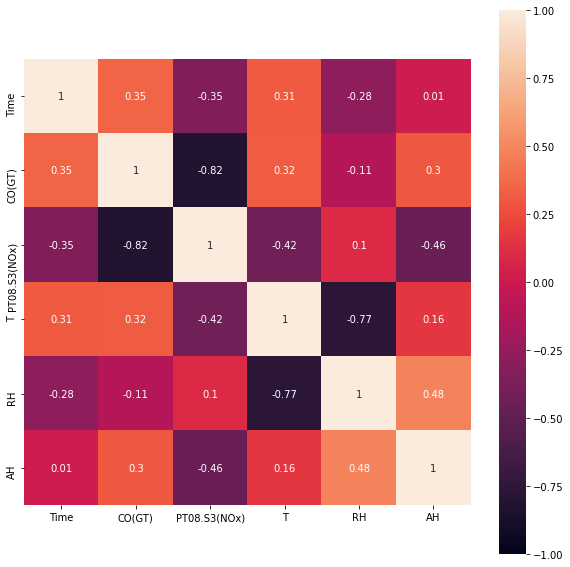

In [52]:
# Matriz de correlación
corrMatrix = air_q.corr()

plt.rcParams['figure.figsize'] = 10, 10
data = np.round(corrMatrix, 2)
sb.heatmap(data, annot = True, vmin=-1, vmax=1, square=True)

## Preprocesado de datos

In [61]:
# AH será la variable predictora
# Se aislan las variables de entrada 'X' de la variable predictiva 'y'
X = air_q.drop('AH', axis=1)     # Variables 'X', todas menos la etiqueta 'AH'
y = air_q['AH']                  # Variable 'y', la etiqueta 'AH'

# Se convierten las variables a numpy para posteriormente poder aplicar reshape y adaptar su dimensión
X = np.nan_to_num(X)
y = np.nan_to_num(y)

# Finalmente, para evitar overfitting se dividen el conjunto de datos en conjunto de entrenamiento y de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)
X_test = X_test.reshape(-X_test.shape[0],X_test.shape[1])    #Reshape de X_test para poder introducirlo

In [66]:
def metricas ():
    print("-----------------------------------------------------")
    print('Métricas de error:')
    print('MAE', metrics.mean_absolute_error(y_test, y_pred))  
    print('MSE', metrics.mean_squared_error(y_test, y_pred))  
    print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    print('Score:', clf.score(X_test, y_test))

## Métricas y resultados

In [69]:
print("RANDOM FOREST")
regr = RandomForestRegressor(max_depth=20, n_estimators = 900, random_state=0)
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)

metricas()

RANDOM FOREST
-----------------------------------------------------
Métricas de error:
MAE 0.03680005391661031
MSE 0.003092377931706585
RMSE: 0.0556091533086648
Score: 0.9072695143667003


In [81]:
print("SVM REGRESSOR - RBF KERNEL")
regr = svm.SVR(kernel='rbf', C = 20)
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)

metricas()

SVM REGRESSOR - RBF KERNEL
-----------------------------------------------------
Métricas de error:
MAE 0.07656587527966698
MSE 0.010154090482937514
RMSE: 0.10076750707910519
Score: 0.9072695143667003


In [85]:
print("LINEAR REGRESSION")
regr = LinearRegression()
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)

metricas()

LOGISTIC REGRESSION
-----------------------------------------------------
Métricas de error:
MAE 0.040577808225924376
MSE 0.0029268456402489883
RMSE: 0.05410032939131691
Score: 0.9072695143667003


In [93]:
print("RIDGE REGRESSION")
reg = Ridge(alpha=0.5)
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)

metricas()

RIDGE REGRESSION
-----------------------------------------------------
Métricas de error:
MAE 0.040577808225924376
MSE 0.0029268456402489883
RMSE: 0.05410032939131691
Score: 0.9072695143667003


OBSERVACIONES: El modelo de regresión con métricas más favorables es el Random Forest de regresión, siendo el modelo de máquinas de vector de soporte el más desfavorables. El comportamiento de la regresión lineal y la regresión ridge es similar.

# 3 - REGLAS DE INFERENCIA

Se pueden extraer reglas de inferencia para comprender el criterio de decisión del modelo seleccionado de Random Forest Regressor, o mejor dicho, a través de uno de sus árboles de decisión.  
Para este ejemplo se utilizará la librería dtreeviz, aunque otras a través de graphviz también son muy interesantes.

In [ ]:
# Al emplear Google Colab es preciso añadir los módulos en el sistema
import sys
if 'google.colab' in sys.modules:
  !pip install -q dtreeviz

In [96]:
import sys
import os
# De la misma manera, la librería ha de incorporarse a PYTHONPATH para funcionar en Google Colab
sys.path.append(f"{os.getcwd()}/../")

In [97]:
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG

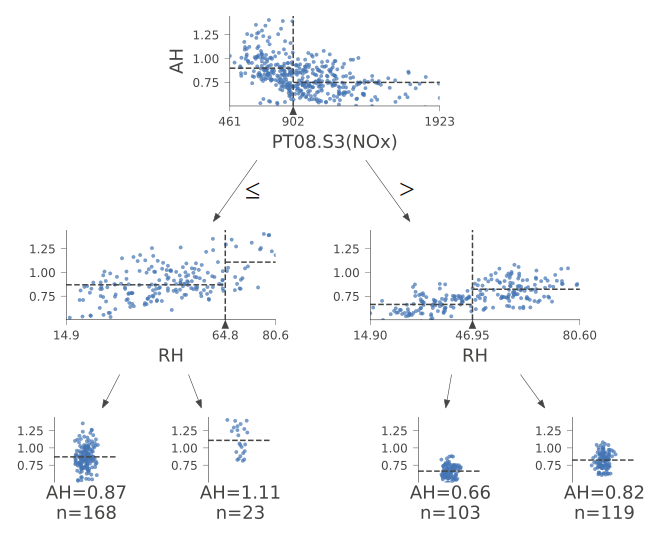

In [104]:
regr = tree.DecisionTreeRegressor(max_depth=2)
regr.fit(X, y)

feature_names = list(air_q.drop('AH', axis=1).columns)

viz = dtreeviz(regr,
               X_train,
               y_train,
               target_name='AH',  
               feature_names=feature_names,
               scale=2,
               histtype= 'barstacked')  # barstackes is default
              
viz

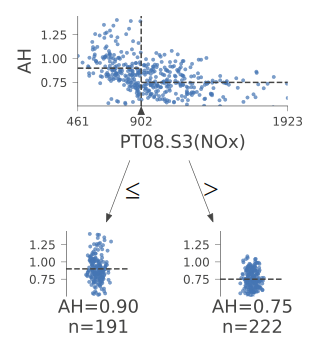

In [105]:
regr = tree.DecisionTreeRegressor(max_depth=1)
regr.fit(X, y)

feature_names = list(air_q.drop('AH', axis=1).columns)

viz = dtreeviz(regr,
               X_train,
               y_train,
               target_name='AH',  
               feature_names=feature_names,
               scale=2,
               histtype= 'barstacked')  # barstackes is default
              
viz

OBSERVACIONES: PT08.S3(N0x) resulta la variable más determinante, principalmente antes y después de su valor 902. La tendencia es que, por debajo de 902 AH se aproxime a 0.90; mientras que, por encima de ese valor de PT08.S3(N0x), AH tiende a 0.75.